In [1]:
# depth_plots.ipynb
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from os import listdir, walk, getcwd
from os.path import isfile, join
import json
import sys

In [3]:
# parse metadata
# filename = "data/Chest_xray_Corona_Metadata.csv"
filename = "data/data/Chest_xray_Corona_Metadata.csv"
meta_df = pd.read_csv(filename, header=0)
meta_df.head(10)

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
5,5,IM-0117-0001.jpeg,Normal,TRAIN,NaN,NaN
6,6,IM-0115-0001.jpeg,Normal,TRAIN,NaN,NaN
7,7,IM-0189-0001.jpeg,Normal,TRAIN,NaN,NaN
8,8,IM-0187-0001.jpeg,Normal,TRAIN,NaN,NaN
9,9,IM-0185-0001.jpeg,Normal,TRAIN,NaN,NaN


In [4]:
print("--- Dataset summary ---")
N = meta_df.shape[0]
for sample_type in meta_df.Dataset_type.unique().tolist():
    n_sample = meta_df[(meta_df.Dataset_type==sample_type)].shape[0]
    print("-> {:5s} ({:4}/{:4}={:2.2f}%)".format(sample_type,n_sample,N,100*n_sample/N))
    for label in meta_df.Label.unique().tolist():
        print("--> {:8s} (N={})".format(label,meta_df[(meta_df.Label==label) & (meta_df.Dataset_type==sample_type)].shape[0]))

--- Dataset summary ---
-> TRAIN (5286/5910=89.44%)
--> Normal   (N=1342)
--> Pnemonia (N=3944)
-> TEST  ( 624/5910=10.56%)
--> Normal   (N=234)
--> Pnemonia (N=390)


In [6]:
# create dict mapping image names to labels
label_dict = dict()
lim = 10
i = 0
for i, row in meta_df.iterrows():
    label_dict[row.X_ray_image_name] = [row.Label, row.Label_2_Virus_category, row.Label_1_Virus_category]
CLASS_NAMES = meta_df.Label.unique()

In [5]:
# scan images, summarize image sizes
from os import listdir, walk, getcwd
from os.path import isfile, join

def collect_files(path, subpaths):
    f=[]
    i=0
    for subpath in subpaths:
        for (dirpath, dirnames, filenames) in walk("{}/{}".format(path,subpath)):
            for file in filenames:
                f.append("{}/{}/{}".format(path,subpath,file))
            break
    return f

path="data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
subpaths=["test","train"]
f = collect_files(path, subpaths)

## Scanning the images

- Problems:
    - Images have different dimensions:
        - Number of rows/cols
        - Need consistent input sizes
    - Images have different color channels
        - Some are greyscale => img.shape = (rows, cols)
        - Some are RGB => img.shape = (rows, cols, RGB)
    - Images do not have metadata and labels
        - Need to skip images not included in the metadata .csv since they are not labeled

In [8]:
from skimage.io import imread
import pandas as pd

def shape_rgb_or_grey(img):
    """
    : Report whether img is RGB or greyscale
    """
    shp = img.shape
    color = "RGB" if len(shp) == 3 else "GREY"
    return [shp[0], shp[1], color] 

def summarize_images(f,meta_df):
    '''
    : Summarize the images contained in file hierarchy (f)
    '''
    datasplit_list=[]
    row_nums=[]
    col_nums=[]
    aspect_ratios=[]
    name_short=[]
    labels_list=[]
    file_type=[]
    color_list=[]
    bad_images=[]
    print("--- Parsing {} images ---".format(len(f)))
    print_every = 500
    i = 0

    for filename in f:
        file_short = filename.split("/")[-1]
        file_ext = filename.split(".")[-1]
        if ( file_ext in ["jpeg","jpg","png"]):
            if (i % print_every == 0):
                print("-> {} images parsed".format(i))
            img = imread(filename)
            try:
                data_split = meta_df[meta_df.X_ray_image_name == file_short].Dataset_type.values[0]
                data_label = meta_df[meta_df.X_ray_image_name == file_short].Label.values[0]
                datasplit_list.append(data_split)
                rows, cols, color = shape_rgb_or_grey(img)
                row_nums.append(rows)
                col_nums.append(cols)
                aspect_ratios.append(cols/rows)
                name_short.append(filename.split("/")[-1])
                labels_list.append(data_label)
                file_type.append(file_ext)
                color_list.append(color)
                i += 1
            except ValueError:
                print(ValueError)
                print("{} - shape = {}".format(filename, img.shape))
            except IndexError:
                bad_images.append(file_short)
                print(f'--> {file_short} is not in metadata. Skipping.')
            except:
                print("Unexpected error:", sys.exc_info()[0])
                print(file_short)
                raise

        else:
            print("Skipping {}.".format(filename))

    # summarize image sizes
    data = {"name": name_short, "dataset_type": datasplit_list, "ext": file_type, "color": color_list, "label": labels_list, "n_rows": row_nums, "n_cols": col_nums, "asp_ratio": aspect_ratios}
    df_sizes = pd.DataFrame(data=data,columns=["name", "dataset_type", "ext", "color", "label", "n_rows", "n_cols", "asp_ratio"])
    print(f"--- There were {len(bad_images)} images not included in the metadata .csv ---")
    return [df_sizes, bad_images]
    

In [9]:
df_sizes, bad_images = summarize_images(f,meta_df)
df_sizes.describe()

--- Parsing 5933 images ---
-> 0 images parsed
-> 500 images parsed
--> 1-s2.0-S0929664620300449-gr3_lrg-a.jpg is not in metadata. Skipping.
--> 1-s2.0-S0929664620300449-gr3_lrg-b.jpg is not in metadata. Skipping.
--> 1-s2.0-S0929664620300449-gr3_lrg-c.jpg is not in metadata. Skipping.
--> 1-s2.0-S0929664620300449-gr3_lrg-d.jpg is not in metadata. Skipping.
--> 191F3B3A-2879-4EF3-BE56-EE0D2B5AAEE3.jpeg is not in metadata. Skipping.
--> 21DDEBFD-7F16-4E3E-8F90-CB1B8EE82828.jpeg is not in metadata. Skipping.
--> 396A81A5-982C-44E9-A57E-9B1DC34E2C08.jpeg is not in metadata. Skipping.
--> 3ED3C0E1-4FE0-4238-8112-DDFF9E20B471.jpeg is not in metadata. Skipping.
--> 5083A6B7-8983-472E-A427-570A3E03DDEE.jpeg is not in metadata. Skipping.
--> 66298CBF-6F10-42D5-A688-741F6AC84A76.jpeg is not in metadata. Skipping.
--> 6A7D4110-2BFC-4D9A-A2D6-E9226D91D25A.jpeg is not in metadata. Skipping.
--> 925446AE-B3C7-4C93-941B-AC4D2FE1F455.jpeg is not in metadata. Skipping.
--> DE488FE1-0C44-428B-B67A-0974

,n_rows,n_cols,asp_ratio
count,5910.000000,5910.000000,5910.000000
mean,973.475296,1328.450085,1.439446
std,389.779755,373.718229,0.256133
min,127.000000,255.000000,0.835391
25%,688.000000,1056.000000,1.257143
50%,888.000000,1283.000000,1.412420
75%,1194.000000,1560.000000,1.583614
max,3480.000000,4248.000000,3.378788


In [7]:
# visualize distribution of image sizes
import matplotlib.pyplot as plt

def df_size_plots(df_sizes):
    fig, axs = plt.subplots(1,2,figsize=(10,3))
    # img size distribution
    hist2d = axs[0].hist2d(df_sizes["n_rows"],df_sizes["n_cols"],bins=50, cmap=plt.cm.jet)
    plt.colorbar(hist2d[3],ax=axs[0])
    axs[0].set_title("Image Size Distribution")
    axs[0].set_xlabel("# Rows")
    axs[0].set_ylabel("# Cols")
    # rgb/color distribution
    colors = ["RGB","GREY"]
    vals = [df_sizes[df_sizes["color"]==color].shape[0] for color in colors]
    axs[1].bar(colors,vals)
    axs[1].set_title("Image Color Distribution")
    axs[1].set_ylabel("Count")
    plt.show()

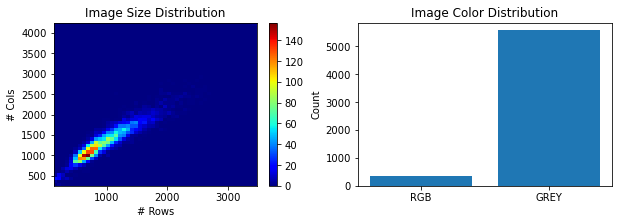

In [11]:
df_size_plots(df_sizes)

In [4]:
# import resizing snippets
from conversion import *

test_path = 'data/data/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'
test_dest = 'data/data/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test_unique'

train_path = 'data/data/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
train_dest = 'data/data/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train_unique'

list_unique_x_ray(test_path,test_dest,False,True) # 
list_unique_x_ray(train_path,train_dest,False,True) # 

--- Beginning processiong of unique 191 files ---
100 files processed out of 191 files.
--- Beginning processiong of unique 1489 files ---
100 files processed out of 1489 files.
200 files processed out of 1489 files.
300 files processed out of 1489 files.
400 files processed out of 1489 files.
500 files processed out of 1489 files.
600 files processed out of 1489 files.
700 files processed out of 1489 files.
800 files processed out of 1489 files.
900 files processed out of 1489 files.
1000 files processed out of 1489 files.
1100 files processed out of 1489 files.
1200 files processed out of 1489 files.
1300 files processed out of 1489 files.
1400 files processed out of 1489 files.


In [ ]:
path="data/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
subpaths=["test_modified/Normal","test_modified/Pnemonia","train_modified/Normal","train_modified/Pnemonia"]
f = collect_files(path, subpaths)
df_sizes, bad_images = summarize_images(f, meta_df)
df_sizes.describe()
df_size_plots(df_sizes)

In [10]:
# save df_sizes to csv so we can reference this when choosing CNN input size
df_sizes.to_csv("data/data/sorted_metadata.csv",index=False)

## Tensorflow Code - CNN-based Classifier

**TO-DO** -- Determine source of error in `resnet.fit()`. Throws the following error:

> `UnboundLocalError: local variable 'logs' referenced before assignment`

In [1]:
# load images with tf.data.Dataset
# see here: https://www.tensorflow.org/tutorials/load_data/images
import tensorflow as tf
print(tf.__version__)
import pandas as pd
import numpy as np
import os
AUTOTUNE = tf.data.experimental.AUTOTUNE
import pathlib

SCALE_DOWN_FACTOR = 3

# df_sizes = pd.read_csv("data/data/data/sorted_metadata.csv")
# path="data/data/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
# BATCH_SIZE = 16
# IMG_HEIGHT = int(df_sizes.n_rows.mean()/SCALE_DOWN_FACTOR)
# IMG_WIDTH = int(df_sizes.n_cols.mean()/SCALE_DOWN_FACTOR)
path="data/data/data/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
CLASS_NAMES = np.array(["Normal", "Pnemonia"])
train_path = f"{path}/train_modified"
data_dir = pathlib.Path(train_path)

list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
# print(list_ds)
# for f in list_ds.take(5):
#     print(f.numpy())

2.0.0


In [2]:
print(list_ds)

<DatasetV1Adapter shapes: (), types: tf.string>


In [3]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES

def get_onehot(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    onehot = tf.reshape(tf.one_hot(tf.where(CLASS_NAMES==parts[-2]),2), (2,))
    print(onehot.shape)
    return onehot

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=1)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

def process_path(file_path):
    # label = get_label(file_path)
    label = get_onehot(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [4]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

(2,)


NameError: in converted code:

    <ipython-input-3-5c02571e46c7>:27 process_path  *
        img = decode_img(img)
    <ipython-input-3-5c02571e46c7>:20 decode_img  *
        return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

    NameError: name 'IMG_HEIGHT' is not defined


In [23]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (324, 442, 1)
Label:  [0. 1.]


In [24]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=500):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

        ds = ds.shuffle(buffer_size=shuffle_buffer_size)

        # Repeat forever
        ds = ds.repeat()

        ds = ds.batch(BATCH_SIZE)

        # `prefetch` lets the dataset fetch batches in the background while the model
        # is training.
        ds = ds.prefetch(buffer_size=AUTOTUNE)

        return ds

In [ ]:
filename = 'data/train_cache'
train_ds = prepare_for_training(labeled_ds,cache=filename)

image_batch, label_batch = next(iter(train_ds))

In [7]:
print(label_batch)

tf.Tensor(
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]], shape=(32, 2), dtype=float32)


In [18]:
import matplotlib.pyplot as plt
import numpy as np

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        im = image_batch[n]
        n_row, n_col, _ = im.shape
        im = np.reshape(im, (n_row, n_col))
        plt.imshow(im, cmap='gray')
        plt.title(CLASS_NAMES[tf.where(label_batch[n]==1)][0].title())
        plt.axis('off')

/home/mason_delro_gmail_com/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if sys.path[0] == '':


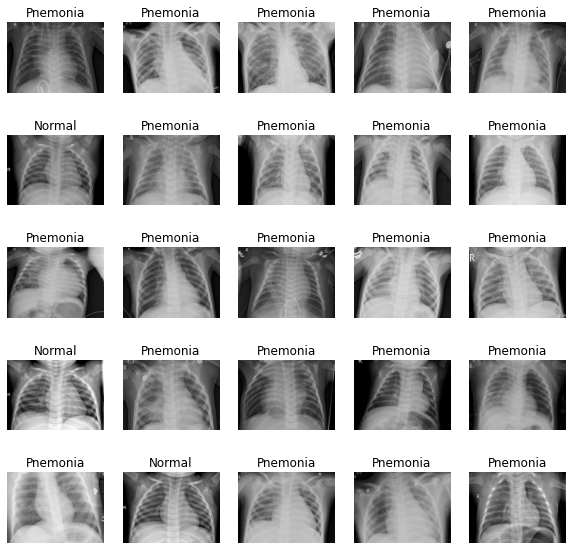

In [19]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [ ]:
data_format = "channels_last"
inp_shape = (IMG_HEIGHT,IMG_WIDTH,1) # channels_last
input_tensor = None
resnet = tf.keras.applications.ResNet50(
    include_top=True, weights=None, input_tensor=input_tensor, input_shape=inp_shape,
    pooling=None, classes=2
)

num_examples = df_sizes[df_sizes.dataset_type == "TRAIN"].shape[0]
full_batches = num_examples // BATCH_SIZE

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_path = "model/resnet50"
model_json = resnet.to_json()
model_out_base = "{}/model_H{}_W{}".format(model_path,IMG_HEIGHT,IMG_WIDTH)
weights_file = "{}.h5".format(model_out_base)

checkpoint = ModelCheckpoint(
    filepath=weights_file,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True
)

In [ ]:
resnet.compile(optimizer='adam',
               loss=tf.keras.losses.CategoricalCrossentropy(), 
               metrics=['accuracy']
              ) 
resnet.summary()
resnet.fit(train_ds,
           epochs=100,
           steps_per_epoch=full_batches,
           callbacks=[checkpoint],
           verbose=1)

In [13]:
# save model+weights for testing later

model_path = "model/resnet50"
model_json = resnet.to_json()
model_out_base = "{}/model_H{}_W{}".format(model_path,IMG_HEIGHT,IMG_WIDTH)
with open("{}.json".format(model_out_base), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
resnet.save("{}.h5".format(model_out_base))

In [17]:
# test model on training set for now
# TO-DO: Functionalize pipeline to get tf.Data obj for test set
resnet.evaluate(train_ds,steps=full_batches)

165/165 [==============================] - 915s 6s/step - loss: 3.9446 - accuracy: 0.7466


[3.944648027420044, 0.7465909123420715]